# MGTA_415 Final Project: Fake News Detection

* Team member names:
    - David Yang
    - Jack Chen
* GitHub userid: rsm-day008, rsm-yuc172

### Load Required Modules And Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import time

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score

In [54]:
import os
os.getcwd()

'c:\\Users\\david\\Desktop'

### Import Data

In [55]:
abs_path = 'c:/Users/david/Desktop'
fake = pd.read_csv(abs_path + "/Fake.csv")
true = pd.read_csv(abs_path + "/True.csv")
test_set_fix = pd.read_csv(abs_path + '/test.csv')
test_set_fix['label'] = np.where(test_set_fix['label']=='FAKE', 1, 0)
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)
print('Test set data:',test_set_fix.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)
Test set data: (6335, 4)


In [56]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [57]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [58]:
test_set_fix.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [59]:
fake['class'] = 1
true['class'] = 0

In [60]:
train_set_fix = pd.concat([fake, true], axis=0)
train_set_fix.reset_index(inplace=True)
train_set_fix.drop(["index"], axis=1, inplace=True)
test_set_fix.drop(['Unnamed: 0'], axis=1, inplace=True)

In [61]:
train_set_fix.shape

(44898, 5)

In [62]:
train_set_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [63]:
train_set_fix.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [64]:
# shuffle the dataset
train_set_fix = train_set_fix.sample(frac=1, random_state=42)

### Exploratory Data Analysis

In [65]:
class_counts = train_set_fix['class'].value_counts().sort_index()
class_counts

0    21417
1    23481
Name: class, dtype: int64

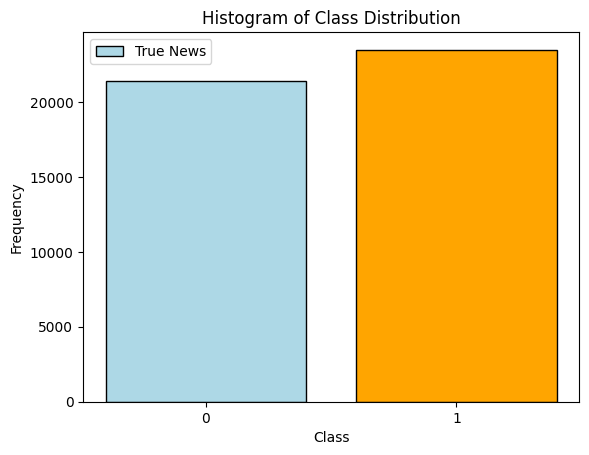

In [66]:
plt.bar(class_counts.index, class_counts.values, color=['#add8e6', '#ffa500'], edgecolor='black', label=['True News', 'Fake News'])

plt.legend(labels=['True News', 'Fake News'])
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.show()

In [67]:
subject_counts = train_set_fix['subject'].value_counts().sort_index()
subject_counts

Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: subject, dtype: int64

In [68]:
train_set_fix[train_set_fix['subject'] == 'worldnews']['class'].value_counts()

0    10145
Name: class, dtype: int64

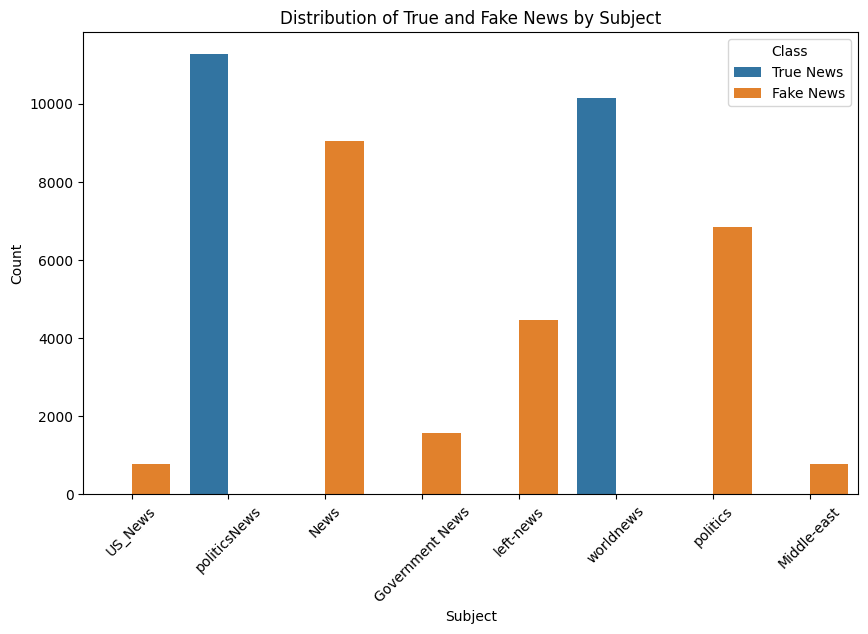

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='class', data=train_set_fix)

plt.title('Distribution of True and Fake News by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['True News', 'Fake News'])

plt.show()

We found that only subjects from "politicsNews" and "Worldnews" are true, while all other subjects are fake. \
Thus, using 'subject' feature to predict will lead to perfect prediction.

### Data Preprocessing (Result stored in JSON format for repetitive use)

In [70]:
"""
train_set = train_set_fix.copy()
test_set = test_set_fix.copy()
"""

'\ntrain_set = train_set_fix.copy()\ntest_set = test_set_fix.copy()\n'

In [71]:
"""
def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)

test_set['text'] = test_set['text'].apply(process_news)
train_set['text'] = train_set['text'].apply(process_news)
train_set['text'].head()
"""

"\ndef process_news(text):\n    text = text.lower()\n    text = re.sub(r'https?://S+ | www\\.\\S+', '', text)\n    text = re.sub(r'\n', '', text)\n    text = re.sub('\\[.*?\\]', '', text)\n    words=[]\n    for i in text:\n        if i not in string.punctuation:\n            words.append(i)\n    return ''.join(words)\n\ntest_set['text'] = test_set['text'].apply(process_news)\ntrain_set['text'] = train_set['text'].apply(process_news)\ntrain_set['text'].head()\n"

In [72]:
"""
# new process without stemming
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
ps = PorterStemmer()

# Tokenization + stop words removal 
def preprocess_stem_stop(doc, stemming=True, build_sent=False):
    tokens = []
    sentences = sent_tokenize(doc)
    for sent in sentences:
        words = word_tokenize(sent)
        if build_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w for w in tokens if w not in stop]

test_set['text'] = test_set['text'].apply(preprocess_stem_stop)
train_set['text'] = train_set['text'].apply(preprocess_stem_stop)
train_set['text'].head()
"""

"\n# new process without stemming\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize, sent_tokenize\nfrom nltk.stem import PorterStemmer\n\nstop = set(stopwords.words('english'))\nps = PorterStemmer()\n\n# Tokenization + stop words removal \ndef preprocess_stem_stop(doc, stemming=True, build_sent=False):\n    tokens = []\n    sentences = sent_tokenize(doc)\n    for sent in sentences:\n        words = word_tokenize(sent)\n        if build_sent:\n            tokens.append(words)\n        else:\n            tokens += words\n    return [w for w in tokens if w not in stop]\n\ntest_set['text'] = test_set['text'].apply(preprocess_stem_stop)\ntrain_set['text'] = train_set['text'].apply(preprocess_stem_stop)\ntrain_set['text'].head()\n"

In [73]:
"""
train_set.to_json('data/train_set_tokenized.json', orient='records', lines=True)
test_set.to_json('data/test_set_tokenized.json', orient='records', lines=True)
"""

"\ntrain_set.to_json('data/train_set_tokenized.json', orient='records', lines=True)\ntest_set.to_json('data/test_set_tokenized.json', orient='records', lines=True)\n"

In [74]:
train_set = pd.read_json(abs_path + '/train_set_tokenized.json', orient='records', lines=True)
test_set = pd.read_json(abs_path + '/test_set_tokenized.json', orient='records', lines=True)

In [75]:
train_set

,title,text,subject,date,class
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"[21st, century, wire, says, ben, stein, reputa...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,"[washington, reuters, us, president, donald, t...",politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,"[reuters, puerto, rico, governor, ricardo, ros...",politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"[monday, donald, trump, embarrassed, country, ...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"[glasgow, scotland, reuters, us, presidential,...",politicsNews,"June 24, 2016",0
...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,[],politics,"Mar 27, 2017",1
44894,PM May seeks to ease Japan's Brexit fears duri...,"[londontokyo, reuters, british, prime, ministe...",worldnews,"August 29, 2017",0
44895,Merkel: Difficult German coalition talks can r...,"[berlin, reuters, chancellor, angela, merkel, ...",worldnews,"November 16, 2017",0
44896,Trump Stole An Idea From North Korean Propaga...,"[jesus, fcking, christ, president, moron, sati...",News,"July 14, 2017",1


In [76]:
test_set

,title,text,label
0,You Can Smell Hillary’s Fear,"[daniel, greenfield, shillman, journalism, fel...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,"[google, pinterest, digg, linkedin, reddit, st...",1
2,Kerry to go to Paris in gesture of sympathy,"[us, secretary, state, john, f, kerry, said, m...",0
3,Bernie supporters on Twitter erupt in anger ag...,"[—, kaydee, king, kaydeeking, november, 9, 201...",1
4,The Battle of New York: Why This Primary Matters,"[primary, day, new, york, frontrunners, hillar...",0
...,...,...,...
6330,State Department says it can't find emails fro...,"[state, department, told, republican, national...",0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,"[‘, p, ’, pbs, stand, ‘, plutocratic, ’, ‘, pe...",1
6332,Anti-Trump Protesters Are Tools of the Oligarc...,"[antitrump, protesters, tools, oligarchy, ref...",1
6333,"In Ethiopia, Obama seeks progress on peace, se...","[addis, ababa, ethiopia, —president, obama, co...",0


### Base ML models (only use 'text' feature)

In [77]:
x_train = train_set['text']
y_train = train_set['class']
x_test = test_set['text']
y_test = test_set['label']

In [78]:
# New var since stop words ans stemming took time
x_train_ = x_train.apply(lambda x: ' '.join(x))
x_test_ = x_test.apply(lambda x: ' '.join(x))  # This is for tfidf transformation below, since it only takes string as input. 


In [79]:
vector = TfidfVectorizer()
x_train_v = vector.fit_transform(x_train_)
x_test_v = vector.transform(x_test_)

## `Base Model - TF-IDF + Logistic Regression`

In [80]:
# new LR without stemming
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(max_iter=50)
base_model = logit.fit(x_train_v, y_train)

predict_base = base_model.predict(x_test_v)

print("Accuracy: ", accuracy_score(y_test, predict_base))
print("Precision: ", precision_score(y_test, predict_base))
print("Recall: ", recall_score(y_test, predict_base))
print("F1-Score: ", f1_score(y_test, predict_base))
print("AUC: ", roc_auc_score(y_test, predict_base))

Accuracy:  0.58689818468824
Precision:  0.5514194397443128
Recall:  0.9269911504424779
F1-Score:  0.6915006483555347
AUC:  0.5872735632376376


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_base))

              precision    recall  f1-score   support

           0       0.77      0.25      0.37      3171
           1       0.55      0.93      0.69      3164

    accuracy                           0.59      6335
   macro avg       0.66      0.59      0.53      6335
weighted avg       0.66      0.59      0.53      6335



In [82]:
"""
# old LR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(max_iter=50)
base_model = logit.fit(x_train_v, y_train)

predict_base = base_model.predict(x_test_v)

print("Accuracy: ", accuracy_score(y_test, predict_base))
print("Precision: ", precision_score(y_test, predict_base))
print("Recall: ", recall_score(y_test, predict_base))
print("F1-Score: ", f1_score(y_test, predict_base))
print("AUC: ", roc_auc_score(y_test, predict_base))
"""

'\n# old LR\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import roc_auc_score\n\nlogit = LogisticRegression(max_iter=50)\nbase_model = logit.fit(x_train_v, y_train)\n\npredict_base = base_model.predict(x_test_v)\n\nprint("Accuracy: ", accuracy_score(y_test, predict_base))\nprint("Precision: ", precision_score(y_test, predict_base))\nprint("Recall: ", recall_score(y_test, predict_base))\nprint("F1-Score: ", f1_score(y_test, predict_base))\nprint("AUC: ", roc_auc_score(y_test, predict_base))\n'

## `Second Model - Word2Vec + Logistic Regression`

In [83]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [84]:
def document_vector(word2vec_model, doc_tokens):
    # Remove out-of-vocabulary words
    doc_tokens = [token for token in doc_tokens if token in word2vec_model.key_to_index]
    if not doc_tokens:
        return np.zeros(word2vec_model.vector_size)
    # Compute mean of word vectors for the document
    return np.mean([word2vec_model[token] for token in doc_tokens], axis=0)

In [85]:
train_vectors = np.array([document_vector(wv, tokens) for tokens in train_set['text']])

In [86]:
test_vectors = np.array([document_vector(wv, tokens) for tokens in test_set['text']])

In [87]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_vectors, train_set['class'])

test_predictions = classifier.predict(test_vectors)

print("Accuracy: ", accuracy_score(test_set['label'], test_predictions))
print("Precision: ", precision_score(test_set['label'], test_predictions))
print("Recall: ", recall_score(test_set['label'], test_predictions))
print("F1-Score: ", f1_score(test_set['label'], test_predictions))
print("AUC: ", roc_auc_score(test_set['label'], classifier.predict_proba(test_vectors)[:, 1]))

Accuracy:  0.5867403314917127
Precision:  0.5553079416531604
Recall:  0.8663084702907712
F1-Score:  0.6767901234567901
AUC:  0.7225592751312563


In [88]:
print(classification_report(test_set['label'], test_predictions))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43      3171
           1       0.56      0.87      0.68      3164

    accuracy                           0.59      6335
   macro avg       0.63      0.59      0.55      6335
weighted avg       0.63      0.59      0.55      6335



## `Third Model - GloVe + Logistic Regression`

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'C:/Users/david/Desktop/glove.6B.100d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

In [94]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'C:/Users/david/Desktop/glove.6B.100d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

C:\Users\david\AppData\Local\Temp\ipykernel_14584\3850639838.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [95]:
def sentence_embedding(sentence, model):
    vectors = [model[word] for word in sentence if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [96]:
X_train_embeddings_glove = np.array([sentence_embedding(sentence, model) for sentence in train_set['text']])
X_test_embeddings_glove = np.array([sentence_embedding(sentence, model) for sentence in test_set['text']])

lr_glove = LogisticRegression(max_iter=1000)
lr_glove.fit(X_train_embeddings_glove, train_set['class'])

y_pred_glove = lr_glove.predict(X_test_embeddings_glove)

In [97]:
print("Accuracy: ", accuracy_score(test_set['label'], y_pred_glove))
print("Precision: ", precision_score(test_set['label'], y_pred_glove))
print("Recall: ", recall_score(test_set['label'], y_pred_glove))
print("F1-Score: ", f1_score(test_set['label'], y_pred_glove))
print("AUC: ", roc_auc_score(test_set['label'], lr_glove.predict_proba(X_test_embeddings_glove)[:, 1]))

Accuracy:  0.5463299131807419
Precision:  0.5362318840579711
Recall:  0.6782553729456384
F1-Score:  0.5989394362266257
AUC:  0.5698743073388295


In [98]:
print(classification_report(test_set['label'], y_pred_glove))

              precision    recall  f1-score   support

           0       0.56      0.41      0.48      3171
           1       0.54      0.68      0.60      3164

    accuracy                           0.55      6335
   macro avg       0.55      0.55      0.54      6335
weighted avg       0.55      0.55      0.54      6335



## `Fourth Model - N-Gram (TF-IDF) + Logistic Regression`

In [46]:
# combine a set of n-gram models
vectorizer = TfidfVectorizer(ngram_range=(1, 4))
X_train_vectors = vectorizer.fit_transform(x_train_)
X_test_vectors = vectorizer.transform(x_test_)

In [47]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_vectors, y_train)

predictions = classifier.predict(X_test_vectors)

print("Accuracy: ", accuracy_score(y_test, predictions))
print("Precision: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("F1-Score: ", f1_score(y_test, predictions))
print("AUC: ", roc_auc_score(y_test, classifier.predict_proba(X_test_vectors)[:, 1]))

Accuracy:  0.6271507498026835
Precision:  0.5895089285714286
Recall:  0.8347029077117573
F1-Score:  0.6909994767137624
AUC:  0.7086385746937818


In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53      3171
           1       0.59      0.83      0.69      3164

    accuracy                           0.63      6335
   macro avg       0.65      0.63      0.61      6335
weighted avg       0.65      0.63      0.61      6335



## Since the model performs poorly, re-consider Feature Engineering

In [ ]:
train_set_eng = train_set.copy()
test_set_eng = test_set.copy()

In [ ]:
def find_trump(token_list):
    return 1 if 'trump' in [token.lower() for token in token_list] else 0

def find_obama(token_list):
    return 1 if 'obama' in [token.lower() for token in token_list] else 0
    
def find_election(token_list):
    return 1 if 'election' in [token.lower() for token in token_list] else 0

train_set_eng['is_trump'] = train_set_eng['text'].apply(find_trump)
train_set_eng['is_obama'] = train_set_eng['text'].apply(find_obama)
train_set_eng['is_election'] = train_set_eng['text'].apply(find_election)

test_set_eng['is_trump'] = test_set_eng['text'].apply(find_trump)
test_set_eng['is_obama'] = test_set_eng['text'].apply(find_obama)
test_set_eng['is_election'] = test_set_eng['text'].apply(find_election)

In [ ]:
x_train_eng = train_set['text']
y_train = train_set['class']
x_test_eng = test_set['text']
y_test = test_set['label']

In [ ]:
# New var since stop words ans stemming took time
x_train_eng = x_train_eng.apply(lambda x: ' '.join(x))
x_test_eng = x_test_eng.apply(lambda x: ' '.join(x))  # This is for tfidf transformation below, since it only takes string as input. 

In [ ]:
vector = TfidfVectorizer()
x_train_eng = vector.fit_transform(x_train_eng)
x_test_eng = vector.transform(x_test_eng)

In [ ]:
from scipy.sparse import hstack

# Stacking additional features with hstack (sparse matrix necessary)
x_train_eng = hstack([x_train_eng, train_set_eng[['is_trump', 'is_obama', 'is_election']]])
x_test_eng = hstack([x_test_eng, test_set_eng[['is_trump', 'is_obama', 'is_election']]])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(max_iter=50)
base_model = logit.fit(x_train_eng, y_train)

predict_base = base_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_base))
print("Precision: ", precision_score(y_test, predict_base))
print("Recall: ", recall_score(y_test, predict_base))
print("F1-Score: ", f1_score(y_test, predict_base))
print("AUC: ", roc_auc_score(y_test, predict_base))

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameter space
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    l1_ratio = None if penalty != 'elasticnet' else trial.suggest_uniform('l1_ratio', 0, 1)

    # Create the model with the suggested hyperparameters
    model = LogisticRegression(max_iter=50, penalty=penalty, C=C, solver='saga', l1_ratio=l1_ratio)

    # Perform cross-validation and return the average AUC score
    score = cross_val_score(model, x_train_eng, y_train, scoring='roc_auc', cv=5).mean()
    return score


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust n_trials to your preference

# Fetch the best parameters
best_params = study.best_params
print('Best parameters:', best_params)

# Train the model using the best parameters
best_model = LogisticRegression(**best_params, max_iter=50).fit(x_train_eng, y_train)

# Evaluate the best model
predict_best = best_model.predict(x_test_eng)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy: ", accuracy_score(y_test, predict_best))
print("Precision: ", precision_score(y_test, predict_best))
print("Recall: ", recall_score(y_test, predict_best))
print("F1-Score: ", f1_score(y_test, predict_best))
print("AUC: ", roc_auc_score(y_test, predict_best))


In [ ]:
rf = RandomForestClassifier()
rf_model = rf.fit(x_train_eng, y_train)

predict_rf = rf_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_rf))
print("Precision: ", precision_score(y_test, predict_rf))
print("Recall: ", recall_score(y_test, predict_rf))
print("F1-Score: ", f1_score(y_test, predict_rf))
print("AUC: ", roc_auc_score(y_test, predict_rf))

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=50)
pac_model = pac.fit(x_train_eng, y_train)

predict_pac = pac_model.predict(x_test_eng)

print("Accuracy: ", accuracy_score(y_test, predict_pac))
print("Precision: ", precision_score(y_test, predict_pac))
print("Recall: ", recall_score(y_test, predict_pac))
print("F1-Score: ", f1_score(y_test, predict_pac))


In [ ]:
# models = {
#     # 'Logistic Regression': LogisticRegression(),
#     'Decision Tree': DecisionTreeClassifier(),
#     # 'Random Forest': RandomForestClassifier(random_state=42),
#     # 'Gradient Classifier' : GradientBoostingClassifier(random_state=0)
# }

In [ ]:
# for name, model in models.items():
#     start = time.time()
#     model.fit(xtrain, ytrain)
#     predict = model.predict(xtest)
    
#     LABELS = ['False', 'True']
#     conf_matrix = confusion_matrix(ytest, predict)
#     plt.figure(figsize =(6,5))
#     sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, vmax = 100, annot = True, fmt ="d");
#     plt.title(f'{name}')
#     plt.ylabel('True class')
#     plt.xlabel('Predicted class')
#     plt.show()
#     print("Accuracy: ", accuracy_score(ytest, predict))
#     print("Precision: ", precision_score(ytest, predict))
#     print("Recall: ", recall_score(ytest, predict))
#     print("F1-Score: ", f1_score(ytest, predict))
#     print("Matthews correlation coefficient: ", matthews_corrcoef(ytest, predict))
#     end = time.time()
#     print("Time taken(in sec): ",round(end-start, 2))
#     print('-' * 70, '\n')